#Predicting the Image is Santa or Not

In [ ]:
#importing libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten

In [ ]:
#Loading Api from kaggle for dataset
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
#Downloading data from kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d deepcontractor/is-that-santa-image-classification

is-that-santa-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#As data downloaded in zip file we need to unzip it
import zipfile
zip_ref = zipfile.ZipFile('/content/is-that-santa-image-classification.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**Data Preprocessing**

In [ ]:
#Preprocessing the Training set
#Here size of image is reduced to 64x64, batch of images is kept as 32 and class is defined as 'binary'.
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/content/is that santa/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

Found 614 images belonging to 2 classes.


In [ ]:
#Preprocessing the Test set
#Applying same scale as training set, but only feature scaling is applied. image augmentation is avoided to prevent leakage of testing data.
test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow_from_directory('/content/is that santa/test',
                                            target_size = (64, 64),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 616 images belonging to 2 classes.


In [ ]:
#Initialising the CNN
cnn = tf.keras.models.Sequential()
#STEP 1: ADDING CONVOLUTIONAL LAYER
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
#STEP 2: APPLYING MAX POLLING
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#Note that in image augmentation we kept the image size as 64x64, therefore input_shape should also be same [64,64,3] (here 3 signifies that this is a colorful image (R,G,B))
#Activation function relu is applied to decrease any linearity that might have arrised while applying filters.
#Adding 2nd Convolutional layer
cnn.add(tf.keras.layers.Conv2D(filters = 32,kernel_size = 3, activation = 'relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size = 2, strides = 2))
#STEP 3: FLATTENING
cnn.add(tf.keras.layers.Flatten())
#STEP 4: FULL CONNECTION
cnn.add(tf.keras.layers.Dense(units=64, activation='relu'))
#STEP 5: OUTPUT LAYER
cnn.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
#lets check summary
cnn.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 64)               

**Training the CNN**

In [ ]:
#Compiling the CNN
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
#Training the CNN on the Training set and evaluating it on the Test set
history = cnn.fit(x = training_set, validation_data = test_set, epochs =8)

Epoch 1/8
20/20 [==============================] - 21s 684ms/step - loss: 0.7031 - accuracy: 0.5619 - val_loss: 0.5877 - val_accuracy: 0.7971
Epoch 2/8
20/20 [==============================] - 18s 923ms/step - loss: 0.5136 - accuracy: 0.7915 - val_loss: 0.3840 - val_accuracy: 0.8377
Epoch 3/8
20/20 [==============================] - 14s 717ms/step - loss: 0.3780 - accuracy: 0.8502 - val_loss: 0.3075 - val_accuracy: 0.8864
Epoch 4/8
20/20 [==============================] - 13s 672ms/step - loss: 0.3400 - accuracy: 0.8616 - val_loss: 0.4695 - val_accuracy: 0.8084
Epoch 5/8
20/20 [==============================] - 13s 688ms/step - loss: 0.3039 - accuracy: 0.8534 - val_loss: 0.2765 - val_accuracy: 0.8718
Epoch 6/8
20/20 [==============================] - 13s 665ms/step - loss: 0.2468 - accuracy: 0.8876 - val_loss: 0.2691 - val_accuracy: 0.8880
Epoch 7/8
20/20 [==============================] - 15s 774ms/step - loss: 0.2246 - accuracy: 0.9072 - val_loss: 0.2803 - val_accuracy: 0.8929
Epoch 

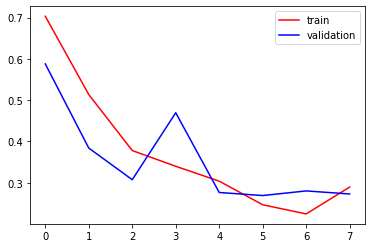

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

* Lets do Some predictions

In [ ]:
cnn.evaluate(test_set)

20/20 [==============================] - 6s 317ms/step - loss: 0.2729 - accuracy: 0.8896


[0.2728874087333679, 0.8896104097366333]

Model accuracy is of 0.8896%

In [ ]:
test_set.class_indices

{'not-a-santa': 0, 'santa': 1}

In [ ]:
#Lets create function for predicting image
from keras.preprocessing import image
def predict_image(img_path):
  test_image = tf.keras.utils.load_img(img_path, target_size = (64, 64))
  test_image = tf.keras.utils.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  img = tf.keras.utils.load_img(img_path,target_size= (300,300))
  result = cnn.predict(test_image)
  training_set.class_indices
  if result[0][0] == 1:
    prediction = 'Its a Santa'
    print(f'This image is {prediction}')
    return img   
  else:
    prediction = 'Not a Santa'
    print(f'This image is {prediction}')
    return img 

1/1 [==============================] - 0s 44ms/step
This image is Not a Santa


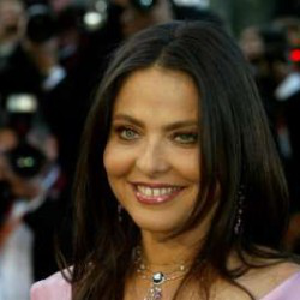

In [ ]:
#Lets check images from the dataset only
predict_image('/content/is that santa/test/not-a-santa/107.not-a-santa.jpg')

1/1 [==============================] - 0s 17ms/step
This image is Its a Santa


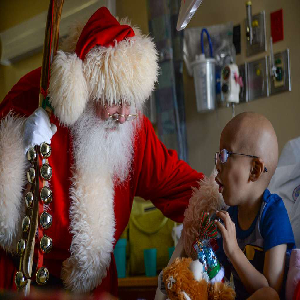

In [ ]:
predict_image('/content/is that santa/train/santa/126.Santa.jpg')